# 1. Data Load


In [1]:
import numpy as np
import pandas as pd
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [ ]:
path = "./Dataset/"

data = pd.read_csv(path+"kwproja_data_location.csv")

# original data -> data
data

# 2. EDA 

**2,927,739 rows X 11 columns**

- 매장 속성 정보
    - shop_code 매장 코드  
    - date 매출 날짜
       - 201606~ 201805 기간 (총 24개의 category) 
    - shop_name 매장명 
    - longtitude 경도
    - latitude : 위도 
        - 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> 군집화, labeling 필요
    - address1 지역구
    - address2 지역동 
        - 매장 위치에 대해 GeoEncoder를 통해 따로 얻은 행정구/동
        - 구(address1) : 30개
        - 동(address2) : 436개
    - shop_type_big 업종 대분류 
        - 매출 영향성 있음 
        - 총 15개의 category)
    - shop_type_small 업종 소분류 
        - 총 61개의 category
- 매장 매출 정보 
    - average_sale_price 월평균 단가 
    - monthly_gain 월 매출 
    - monthly_gain / avearge_sale_price = 한달 총 판매수
- 매출 통계 정보-> X

##### monthly_gain과 average_sale_price 중 어느 것을 y값으로 둘 것인가? 
- 월매출 예측 문제로 가정하고 montly_gain 을 y값으로 예측하는 모델 만들기

##### shop_code는 input feature에 넣어야 하는가?
- 특별한 브랜드가 y값을 결정하는 과적합 요소가 될 수 있으므로
- X 에서 shop code, shop name 제외하는 것도 방법
- 어느 위치에 어떤 업종으로 어떤 객단가인 매장을 오픈하면 월매출이 어떻게 될까? 문제
 - X: shop type big, shop type small, longitude, latitude, avg_sale_price, 
 - y: montly_gain
 
['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price']

In [4]:
data.columns = ['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small', 
                'longitude', 'latitude', 'monthly_gain', 'average_sale_price', 'address1', 'address2']

In [5]:
data.columns

Index(['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price',
       'address1', 'address2'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927739 entries, 0 to 2927738
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                int64  
 1   shop_code           int64  
 2   shop_name           object 
 3   shop_type_big       object 
 4   shop_type_small     object 
 5   longitude           float64
 6   latitude            float64
 7   monthly_gain        float64
 8   average_sale_price  int64  
 9   address1            object 
 10  address2            object 
dtypes: float64(3), int64(3), object(5)
memory usage: 245.7+ MB


# 3. Preprocessing
data -> processed_data

**2,927,739 rows X 11 columns**

- 9 columns : **shop_code | date | shop_name | shop_type_big | shop_type_small | longitude | latitude | average_sale_price | monthly_gain**

- Removing missing value, 결측치 제거
    - A/N, 해당 사항 없음 
- Feature selection, 변수 선택 
    - shop_code : 식별자 feature 이므로 drop 
    - date : 쓸 수 없으므로 drop
- Feature Engineering 
    - longitude, latitude : 
        - ML : k-mean clustering -> geo column 
        - DL : NLP, reverse geo encoder(행정동admcode, 법정동, 지번주소, 도로명주소) -> 행정동 채택
- Encoding, 범주형 변수 수치화 
    - shop_type_big(15), shop_type_small(61) 
        - ML : label encodding, binary encoding -> binary encdoing 최종 채택
        - DL : NLP, 단어 그대로 학습
- Standardization and Normalization 
    - average_sale_price 
        - log transformation 
    - Scaler
        - RobustScaler, StandardScaler -> 실험에 유의미한 변화를 보이지 못했음 
- Removing outlier, 이상치 제거
    - 55,256 개 
    - 단, 선택적인 부분 -> 분류 모델 보다 회귀 모델에서 더 좋은 반응을 보임

**2,694,599 rows X 8 columns**

In [8]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# feature drop : date, shop_code
processed_data = data.drop(['date', 'shop_code'], axis=1).copy()

In [9]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = processed_data[processed_data['monthly_gain']==0].index 
print("monthly gain null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - average_sale_price
null_index = processed_data[processed_data['average_sale_price']==0].index 
print("average sale price null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_big
null_index = processed_data[processed_data['shop_type_big'].isnull()==True].index
print("shop type big null : ", len(null_index))
print("shop type big unique : ", processed_data['shop_type_big'].nunique())
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_small 
null_index = processed_data[processed_data['address1'].isnull()==True].index
print("shop type small null : ", len(null_index))
print("shop type small unique : ", processed_data['address1'].nunique() )

monthly gain null :  0
average sale price null :  0
shop type big null :  0
shop type big unique :  15
shop type small null :  0
shop type small unique :  27


In [ ]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

# fit transform으로 한번에 처리 가능
le_big = LabelEncoder()
processed_data['shop_type_big_label'] = le_big.fit_transform(list(processed_data['shop_type_big']))   
print(le_big.classes_)

le_small = LabelEncoder()
processed_data['shop_type_small_label'] = le_small.fit_transform(list(processed_data['shop_type_small'])) 
print(le_small.classes_)

In [11]:
# BinaryEncoder for categorical variable 
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=["shop_type_big", "shop_type_small"])
df = encoder.fit_transform(processed_data[["shop_type_big", "shop_type_small"]])

processed_data = pd.concat([processed_data, df], axis=1)

C:\Users\Hyeongbin\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [12]:
# NLP용 preprocessing 
# shop_name, shop_type_big, shop_type_small = concat_text 
processed_data['concat_text'] = processed_data['shop_name'] + ' ' + processed_data['shop_type_big'] + ' ' + processed_data['shop_type_small'] + ' '
processed_data['concat_text'] = processed_data['concat_text'] + ' ' + processed_data['address1'] + ' ' + processed_data['address2']
processed_data = processed_data.drop(['shop_name', 'address1', 'address2'], axis=1)

[[ 37.49583685 126.90273576]
 [ 37.57108094 127.0668474 ]
 [ 37.50177308 127.03566714]
 [ 37.5739446  126.92465705]
 [ 37.56571976 126.99365623]
 [ 37.53835404 126.84645794]
 [ 37.51712644 127.1211588 ]
 [ 37.63899078 127.0452175 ]
 [ 37.49414967 126.96097465]]
[6 2 0 ... 2 5 6]


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

C:\Users\Hyeongbin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


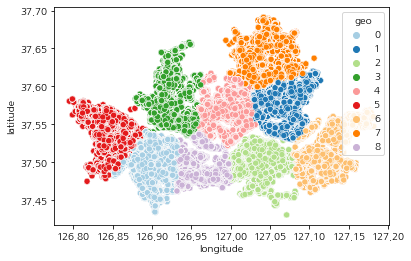

In [13]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
# 위도+ 경도 -> 2차원 
# 숫자 + 숫자 -> 2차원 
# 숫자 + 숫자 + y label 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=9, init='k-means++', n_init=1, random_state = 300).fit(processed_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

processed_data['geo'] = kmeans.labels_

# plotting geo
#score = np.round(silhouette_score(processed_data[['latitude', 'longitude']], kmeans.labels_),3)
       
sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=processed_data, palette="Paired")
#plt.title(str(score))

# NLP 처리를 위해서 featrue drop은 생략합니다! 
#processed_data = processed_data.drop(['longitude', 'latitude'], axis=1)

In [ ]:
# average_sale_price -> skewed data 
# log transfromation 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']
processed_data[scale_cols] = processed_data[scale_cols].apply(lambda x : np.log1p(x))

processed_data

<AxesSubplot:xlabel='shop_type_big', ylabel='monthly_gain'>

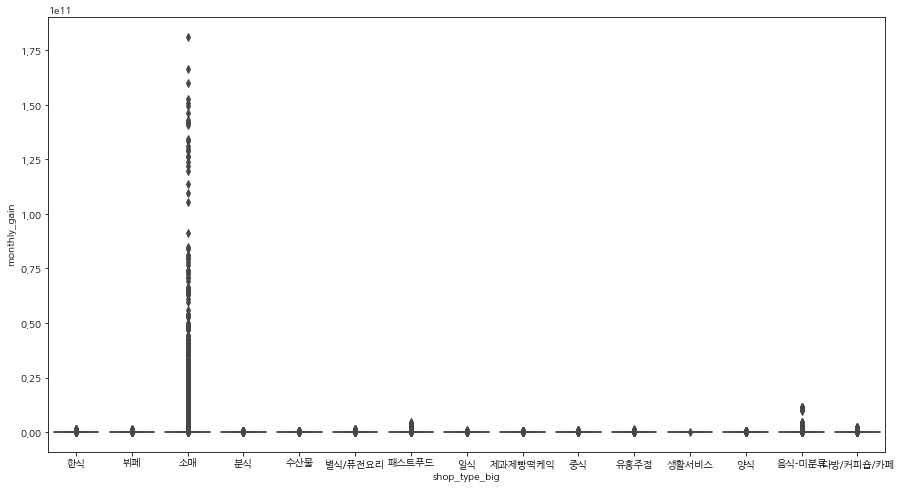

In [16]:
# check the preprocessed 'average_sale_price' by shop_type_big
rcParams['figure.figsize'] = 15,8
sns.boxplot(x='shop_type_big', y='monthly_gain', data=processed_data)

<AxesSubplot:title={'center':'monthly_gain'}, xlabel='[shop_type_big_label]'>

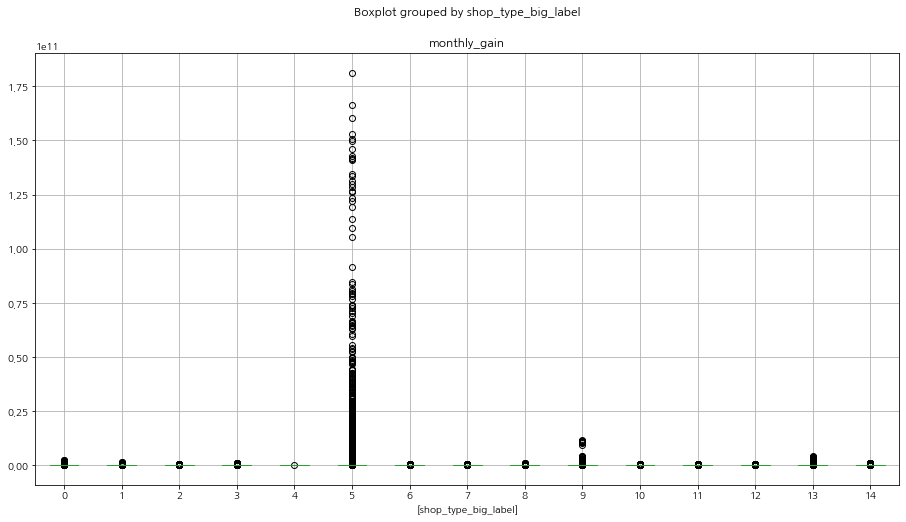

In [28]:
# check the 'monthly_gain'
processed_data.boxplot(column = ['monthly_gain'], by=['shop_type_big_label'])

# 4. Target Variable Labeling and EDA for variable y
processed_data -> labeled_data 
- 어떻게 라벨링 할 것인가? 
- 1. Classification : use mean, std -> failed
- 2. Classification : Quantile 10%, 20%, 25%, 33% -> label 10, 5, 4, 3 
- 3. Classification : Quantile by shop_type_big with lower fence, Q2, upper_fence -> label 31
- 3. Classification : Quantile by shop_type_big with Q1, Q2, Q3 -> label 45
- 4. Classification : price label, min:5, max:181억 -> label 15
- 5. Removing Outlier : outler 233,140 -> total data(without outlier) 2,694,599
- 6. Rounding data 

In [ ]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, labeled data = labeled_data 
labeled_data = processed_data.copy()
labeled_data

In [16]:
group_big_gain = labeled_data[['shop_type_big','average_sale_price']].groupby('shop_type_big')
df_group_big_gain = group_big_gain.describe().droplevel(axis=1,level=0)

# monthly_gain을 shop_type_big 분야별로 정렬하여 출력
print("내림차순 기준 분야별로 정렬하여 출력합니다 - monthly_gain")
print("min: ", list(df_group_big_gain.sort_values(by=['min'], ascending=False).index))
print("mean:", list(df_group_big_gain.sort_values(by=['mean'], ascending=False).index))
print("max: ", list(df_group_big_gain.sort_values(by=['max'], ascending=False).index))

df_group_big_gain

내림차순 기준 분야별로 정렬하여 출력합니다 - monthly_gain
min:  ['생활서비스', '양식', '뷔페', '수산물', '일식', '분식', '패스트푸드', '다방/커피숍/카페', '별식/퓨전요리', '음식-미분류', '제과제빵떡케익', '중식', '한식', '소매', '유흥주점']
mean: ['수산물', '유흥주점', '뷔페', '양식', '생활서비스', '한식', '중식', '별식/퓨전요리', '음식-미분류', '일식', '패스트푸드', '제과제빵떡케익', '분식', '소매', '다방/커피숍/카페']
max:  ['소매', '음식-미분류', '유흥주점', '다방/커피숍/카페', '패스트푸드', '분식', '별식/퓨전요리', '제과제빵떡케익', '중식', '뷔페', '한식', '수산물', '일식', '양식', '생활서비스']


,count,mean,std,min,25%,50%,75%,max
shop_type_big,,,,,,,,
다방/커피숍/카페,318339.00,9.03,0.73,2.40,8.63,8.88,9.22,16.68
별식/퓨전요리,213619.00,10.12,0.60,2.40,9.85,10.10,10.45,16.47
분식,188263.00,9.39,0.58,3.93,9.00,9.27,9.71,16.52
뷔페,24891.00,10.48,0.89,4.62,9.95,10.60,10.92,15.82
생활서비스,47.00,10.29,0.87,8.75,9.62,9.91,11.02,12.01
소매,359034.00,9.31,1.02,0.69,8.65,8.87,9.82,18.92
수산물,131323.00,10.78,0.63,4.62,10.38,10.76,11.16,15.14
양식,13726.00,10.34,0.92,6.91,9.73,10.39,10.85,14.47
유흥주점,254766.00,10.62,0.64,0.69,10.31,10.56,10.85,16.72


Index(['다방/커피숍/카페', '별식/퓨전요리', '분식', '뷔페', '생활서비스', '소매', '수산물', '양식', '유흥주점',
       '음식-미분류', '일식', '제과제빵떡케익', '중식', '패스트푸드', '한식'],
      dtype='object', name='shop_type_big')


<AxesSubplot:xlabel='shop_type_big'>

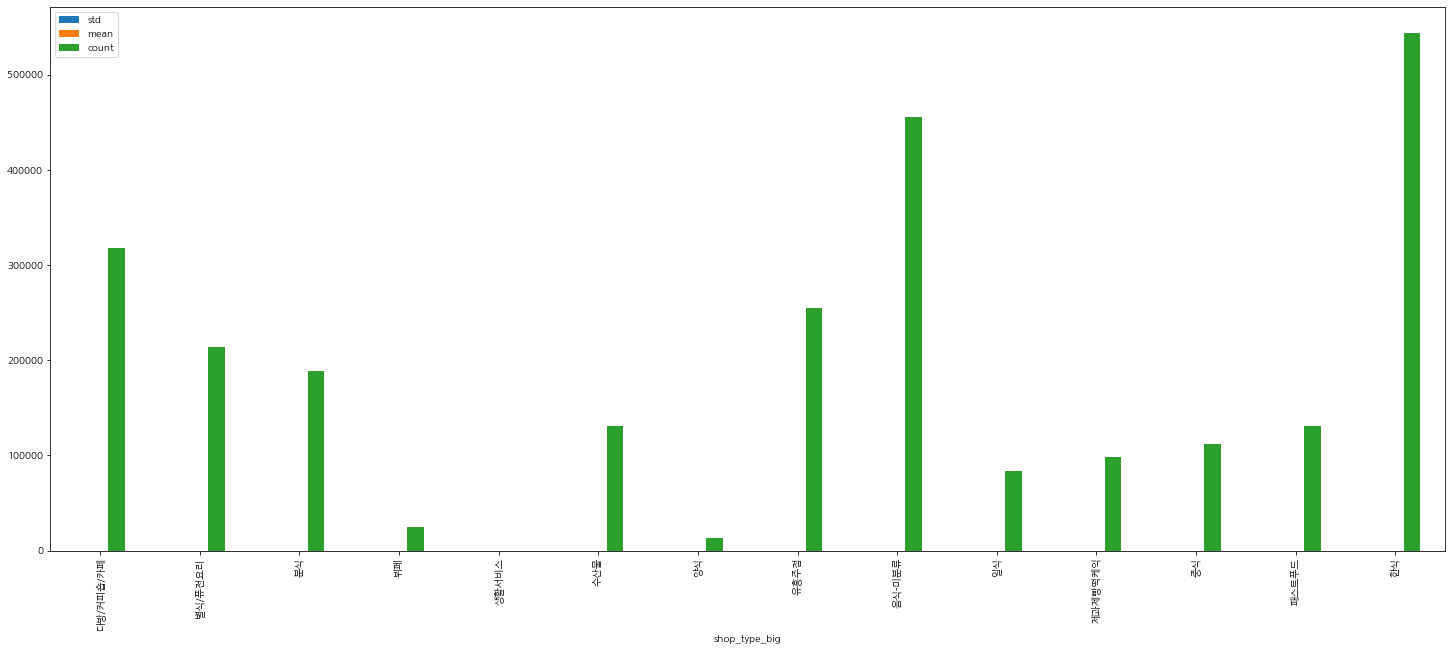

In [17]:
# shop_type_big 으로 묶은 후 shop_type_small 간의 평균 가격대를 비교하는 코드 
# 제조같은 분야는 하나의 소분야가 압도적으로 가격대가 높게 형성되어 있고 나머지는 비슷비슷함
# 스포츠 같은 경우는 모든 소분야가 비슷한 가격대를 형성함 

# shop_type_big 중에서 5번 종목이 가격 분포가 너무 넓어서 그래프를 그렸을 때 다른 종목도 보기 어려워서
# 5번을 드랍하고 보기로 함 -> 전반적으로 평균보다 편차가 훨씬 큼
typebig_list = df_group_big_gain.index
print(typebig_list)

updated_df = df_group_big_gain.drop('소매').copy()
updated_df.plot.bar(y=['std', 'mean', 'count'], figsize=(25,10))

<AxesSubplot:xlabel='shop_type_big', ylabel='average_sale_price'>

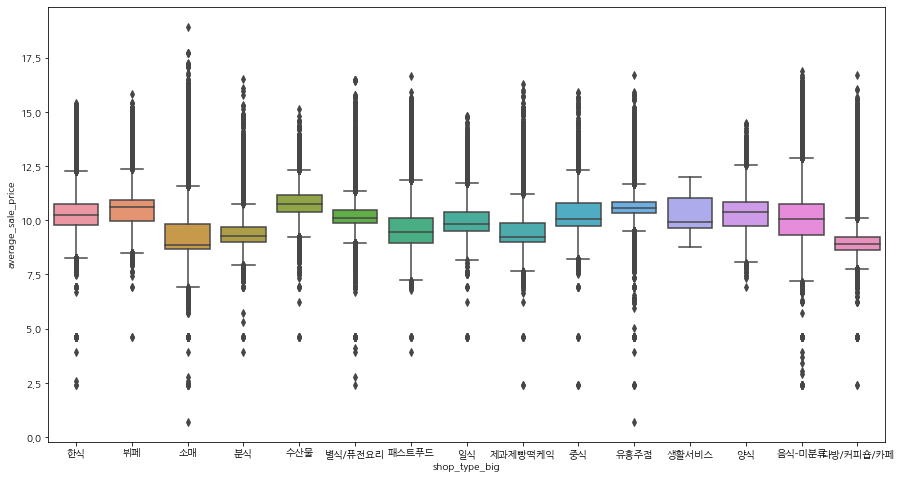

In [18]:
rcParams['figure.figsize'] = 15,8
sns.boxplot(x='shop_type_big', y='average_sale_price', data=labeled_data)

In [ ]:
group_big_gain.get_group(7).boxplot(column='monthly_gain')

In [ ]:
# box plot 상 outlier와 Quantile 상 75% 이상의 값을 확인합니다
# we detect outlier (from upper, lower) and values greater than 75% in the quantile
list_q4 = df_group_big_gain['75%'].values
for i in range(0, 15) :
    Q1 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.25)
    Q3 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    
    df = group_big_gain.get_group(i)['monthly_gain']
    print("%.2f \t" % upper_fence, len(df[df > upper_fence]),
          "\t %.2f \t" % lower_fence, len(df[df < lower_fence]),
          "\t %.2f \t" % list_q4[i], len(df[df > list_q4[i]]))

In [ ]:
# Explore shop_type_small

#df_typesmall = []
#for _ in typebig_list :
#    df = df_check[df_check['shop_type_big'] == _ ].groupby('shop_type_small').describe().droplevel(axis=1,level=0)
#    df_typesmall.append(df)
#df_typesmall[2].plot.bar(y=['std','mean'], figsize=(25,10))

#### Labeling 1) shop_type_big에 따라 중간값, 편차를 이용

- 모든 업종이 중간값 보다 편차가 너무 커서 폐기

In [ ]:
group_big_gain = labeled_data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
df_group_big_gain = group_big_gain.describe().droplevel(axis=1,level=0)

min_dict = df_group_big_gain['min'].to_dict()
mean_dict = df_group_big_gain['mean'].to_dict()
max_dict = df_group_big_gain['max'].to_dict()
std_dict = df_group_big_gain['std'].to_dict()

price_dict = []
def labeling(x) : 
    for i in range(0, 15) :
        max_price = mean_dict[i] + std_dict[i]
        if mean_dict[i]-std_dict[i] <= 0 : min_price = 0 
        else : min_price = mean_dict[i] - std_dict[i]

        if x <= min  : return min/2
        elif x >= max : return  
    return i

print(price_dict)
labeled_data['gain_label'] = labeled_data.monthly_gain.apply(labeling)
labeled_data

#### Labeling 2) quantity하게, 백분율을 이용해서

- **Label(10)**  min 10% 20% ... 80% 90% max의 값을 찾은 후, monthly_gain에 대해 두 범위 사이에 존재하는 값에 대해서 평균 값으로 라벨링 합니다. 
    - 예) min 과 10% 사이의 값 -> min과 10%의 평균 값으로 라벨링
    - 라벨링 분포가 정확히 14432~14430 사이로 떨어짐 -> 오로지 백분율로 잘랐기 때문에 분포에 대한 걱정은 안해도 됨
    - accuracy f-1score : 0.50 ~ 0.49
- **Label(3)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 33 ~ 66 ~ 99(100) -> 총 3개의 label 생성
    - 1: 3,669,015.0075000003, 2: 18,734,738.491500005, 3: 303,196,624.6690003
    - 3백, 2천(1천8백만), 3억
    - accuracy f-1score : 0.84 ~ 0.82
- **Label(4)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 25 ~ 50 ~ 75 ~ 100 -> 총 4개의 label 생성
    - 1: 2,324,858.25, 2: 10,317,593.25, 3: 29,815,219.125, 4: 32,692,544,860.4
    - 2백, 1천만, 3천만(2천9백), 326억
    - accuracy f-1score : 0.78 ~ 0.76
- **Label(5)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 20 ~ 40 ~ 60 ~ 80 ~ 100 -> 총 5개의 label 생성
    - 1: 1,622,880.0, 2: 6,773,160.0, 3: 17,044,674.75,4: 39,214,985.75, 5: 32,698,042,967.275
    - 1백만, 6백만, 1천7백만, 4천(3천9백만), 326억
    - accuracy f-1score : 0.71 ~ 0.70
- 백분율로 자르는 방법
    - labe(10)의 경우 유난히 4~8 label에 대해서는 잘 못맞춤 -> monthly_gain을 일렬로 세웠을 때 앞 뒤로 뭉쳐있어서 그런 것 같음 
    - 무작정 quantity하게 값을 나눠서 라벨링 하는 것은 좋은 것 같지 않음..
    - 앞, 뒤로는 자잘하게 자르고 가운데는 큼직하게 잘라야..?
    - 확실히 class의 개수가 많아질수록 accuracy가 낮아짐

In [15]:
price_dict = {}  # original price를 저장하기 위한 dict
price_list = [0] # 시작 min 값은 0 
for i in range(1, 11) :
    price_list.append(labeled_data['monthly_gain'].quantile(q=i*0.1)) # 10% ~ 100% 값을 가져옵니다    

def labeling(x) : 
    for i in range(1, len(price_list)) :
        price_dict[i] = (price_list[i]+price_list[i-1])/2
        if x < price_list[i] and x >= price_list[i-1] : return i
    return i

labeled_data['gain_label'] = labeled_data.monthly_gain.apply(labeling)
print("label: ", labeled_data['gain_label'].unique())
print(price_dict)
print(price_list)

label:  [10  8  7  2  4  6  5  3  9  1]
{1: 766177.392, 2: 2416853.102, 3: 4367341.306000001, 4: 6771578.880000001, 5: 9842625.509, 6: 13910004.138000002, 7: 19613928.162, 8: 28182833.791999996, 9: 43187748.551, 10: 90645164352.75299}
[0, 1532354.784, 3301351.42, 5433331.192000002, 8109826.568, 11575424.45, 16244583.826000005, 22983272.497999996, 33382395.085999995, 52993102.016, 181237335603.49]


#### Labeling 3) shop_type_big에 따라 Q1, Q2, Q3, upper fence, lower fence값 이용  

- shop_type_big 당 label 3개 : Total lable 30 + 1(lower_fence=0) = 31 
- Q1 ~ 이하 값 : lower fence = 0
- Q1 ~ Q3 : Q2, mid
- Q3 ~ 이상 값 : upper fence 

- shop_type_big 당 label 3개 : Total label 45
- Q1 이하값 : Q1 
- Q1 ~ Q3 : Q2, mid
- Q3 이상값 : Q3

In [ ]:
def get_pricelist(i, data) :
    df = data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
    Q1 = df.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = df.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = df.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def labeling(data) : 
    lable_list = [[0]*5 for i in range(15)]
    for i in range(0,15) : 
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i, data)
        prices = data.loc[(data.shop_type_big_label == i), 'monthly_gain']
        lable_list[i] = [lower_fence, Q1, Q2, Q3, upper_fence ]
        # lower fence, Q2, upper fence 
        #prices = prices.apply(lambda x: lower_fence if x < Q1 else (upper_fence if x > Q3 else Q2))
        prices = prices.apply(lambda x : Q1 if x < Q1 else (Q3 if x > Q3 else Q2))
        data.loc[(data.shop_type_big_label == i), 'gain_label'] = prices
    return data, lable_list 

labeled_data, label_list = labeling(labeled_data)
print("label counts: ", labeled_data['gain_label'].nunique())
print(label_list)
labeled_data.head()

In [21]:
# label dataframe 가공! 
label_df = pd.DataFrame(label_list)

index = le_big.classes_
label_df = label_df.set_index(keys=index, inplace=False)
label_df.columns = ['lower_fence', 'Q1', 'Q2', 'Q3', 'upper_fence']
label_df = label_df.astype(int)

label_df

,lower_fence,Q1,Q2,Q3,upper_fence
다방/커피숍/카페,0,3252624,7505698,15909550,34894938
별식/퓨전요리,0,5770587,12058130,23826346,50909984
분식,0,3471252,8711467,19694451,44029251
뷔페,0,6552622,15851043,36195659,80660215
생활서비스,0,2922138,4186328,6760663,12518452
소매,0,7382320,27178602,47733778,108260966
수산물,0,8455953,18101518,36318652,78112701
양식,0,6093858,13859828,28725833,62673795
유흥주점,0,3687630,9033762,19227524,42537365
음식-미분류,0,2237639,6398832,17318475,39939730


#### Labeling 4) all price range
- min : 5 
- max : 181,237,335,603 (181억)
- 10,000원*
- 100,000원(십만원대)*
- 500,000원(십만~오십만원대)*
- 1,000,000원 (백만원대)
- 2, 3, 4, 5, 6, 7, 8, 9 (detailed)
- 10,000,000원 (천만원대)
- 30,000,000원 
- 50,000,000원
- 70,000,000원
- 100,000,000원 (억대)*
- 500,000,000원 *
- 1,000,000,000원(십억대) *
- 10,000,000,000원(백억대) *

In [26]:
price_dict = [10000, 100000,
              1000000, 3000000, 5000000, 7000000,
              10000000, 30000000, 50000000, 70000000,
              100000000, 500000000, 1000000000, 10000000000, 15000000000]
print(len(price_dict))

def labeling(x) : 
    for i in range(0, len(price_dict)) :
        if x < price_dict[i] : return price_dict[i]
    return price_dict[-1]

labeled_data['gain_label'] = input_data.monthly_gain.apply(labeling)
print(labeled_data['gain_label'].value_counts())

15
30000000.00     921619
3000000.00      343299
50000000.00     311124
5000000.00      284585
10000000.00     281385
7000000.00      235054
1000000.00      177939
70000000.00      97653
100000000.00     22249
100000.00        16747
500000000.00      2140
10000.00           805
Name: gain_label, dtype: int64


#### Option 5) Removing outlier
upper fence, lower fence 외 값(outlier)을 제거합니다 

In [ ]:
def get_pricelist(i, data) :
    df = data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
    Q1 = df.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = df.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = df.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def remove_outlier(data, processed_data) :
    output_data = data.copy()
    for i in range(0,15) :
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i, processed_data)
        shoptype_index = data[data.shop_type_big_label == i].index
        shoptype_data = data.iloc[shoptype_index, :]
        outlier_index = shoptype_data[shoptype_data.monthly_gain > upper_fence].index
        print("removed index in shop_type_big" , i, ": ", len(outlier_index))
        output_data = output_data.drop(outlier_index)
    return output_data 

labeled_data = remove_outlier(labeled_data, processed_data)
labeled_data

<AxesSubplot:>

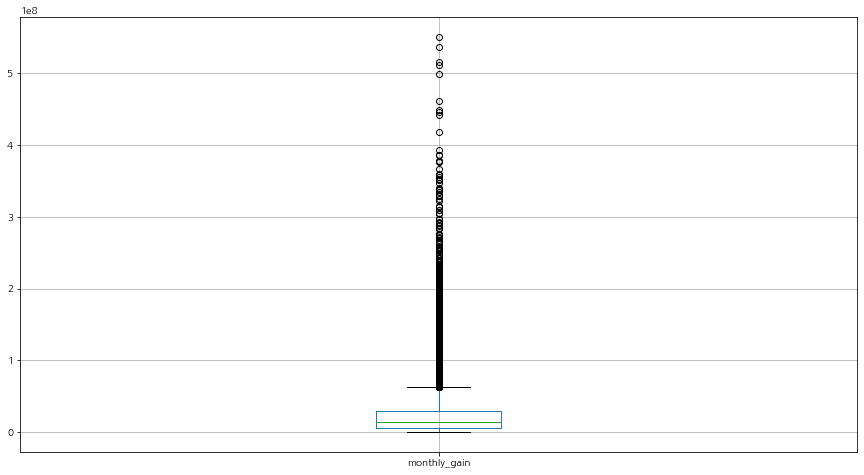

In [31]:
group_big_gain = labeled_data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
df_group_big_gain = group_big_gain.describe().droplevel(axis=1,level=0)
group_big_gain.get_group(7).boxplot(column='monthly_gain')

#### Option 6) Rounding data
십만원대, 백만원대 아래 가격들은 모두 반올림 하여 비슷한 label 값을 가지는 것들은 통일
- label의 개수를 줄임
- 1의 자리~ 10,000의 자리 숫자들은 반올림하에 0으로 처리

In [100]:
print("original monthly_gain_label counts : ", labeled_data['gain_label'].nunique())
labeled_data['gain_label'] = labeled_data.gain_label.apply(lambda x : round(x, -5) if x < 10000000 else round(x, -6))

print("rounded monthly_gain_label value counts :", labeled_data['gain_label'].nunique(), 
      "\n", labeled_data['gain_label'].value_counts())

original monthly_gain_label counts :  45
rounded monthly_gain_label value counts : 36 
 14000000.00    278804
6400000.00     227596
27000000.00    200572
7500000.00     159169
5700000.00     135972
9000000.00     127382
18000000.00    121871
7400000.00     117864
2200000.00     113798
16000000.00    108641
12000000.00    106809
30000000.00     95836
8700000.00      94131
3300000.00      79585
13000000.00     65272
3700000.00      63692
17000000.00     63266
48000000.00     63081
5800000.00      53405
9800000.00      49101
36000000.00     47794
3500000.00      47066
19000000.00     44342
24000000.00     37679
20000000.00     35063
8500000.00      32831
5200000.00      32636
3200000.00      24550
29000000.00     21410
8000000.00      20872
31000000.00     14808
6600000.00       6223
6100000.00       3432
4200000.00         23
2900000.00         12
6800000.00         11
Name: gain_label, dtype: int64


# 5. Data Split 
모든 전처리와 y variable labeling이 완료되었다. train / valid / test data로 분할하고 용도에 맞게 ML, DL을 돌리도록 하자. 

In [18]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# continous 값은 lgbm에서 classification 할 수 없음
# conver 'float' to 'int'
labeled_data = labeled_data.astype({'gain_label' : 'int'})

# labeled된 data와 따로 관리 -> labeled data = labeled_data, model input data = input_data
input_data = labeled_data.copy()

input_data_y = input_data['gain_label'].copy()
input_data_X = input_data.drop(['gain_label', 'monthly_gain'], axis=1)


# LabelEncoder
# y data를 LabelEncdoer로 한 번 더 labeling 합니다 -> 100만원, 10000만원... = 0, 1, ... 
# 추후에 DL에서 output을 맞춰주기 위함입니다, 최종 마지막에서 원래 label값(100만원, 1000만원...)으로 되돌립니다
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 [ 2237639  2922138  3178903  3252624  3471252  3687630  4186328  5233673
  5727531  5770587  6093858  6398832  6552622  6760663  7359411  7382320
  7505698  8029402  8455953  8711467  9033762  9812952 12058130 12564552
 13859828 14123414 15851043 15909550 16006683 17318475 17865797 18101518
 19227524 19694451 23826346 27178602 27443949 28725833 29231947 30392434
 30874311 36184657 36195659 36318652 47733778]
gain_lable label 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44}


In [19]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = tr_val_y
)

# 6. Modeling - ML, XGB, LGBM
- shop_type_big, shop_type_small, geo, average_sale_price
- XGB
- LGBM
- Multi-Class Classification 

In [31]:
# ml용 data에는 _ml을 붙여줍니다 
X_column_ml = ['average_sale_price', 'shop_type_big_0',
       'shop_type_big_1', 'shop_type_big_2', 'shop_type_big_3',
       'shop_type_big_4', 'shop_type_small_0', 'shop_type_small_1',
       'shop_type_small_2', 'shop_type_small_3', 'shop_type_small_4',
       'shop_type_small_5', 'shop_type_small_6', 'geo']

train_X_ml = train_X[X_column_ml].copy()
valid_X_ml = valid_X[X_column_ml].copy()
test_X_ml = test_X[X_column_ml].copy()

print(len(tr_val_X))
print(len(train_X_ml))
print(len(valid_X))
print(len(valid_X_ml))
print(len(test_X))
print(len(test_X_ml))

2342191
1873752
468439
468439
585548
585548


In [32]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 

model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False)
model_lgbm = LGBMClassifier(
    eval_metric='mlogloss')

In [34]:
model_xgb.fit(train_X_ml, train_y, eval_set=[(valid_X_ml, valid_y)])

[0]	validation_0-mlogloss:1.67511
[1]	validation_0-mlogloss:1.46712
[2]	validation_0-mlogloss:1.34834
[3]	validation_0-mlogloss:1.26498
[4]	validation_0-mlogloss:1.20297
[5]	validation_0-mlogloss:1.15508
[6]	validation_0-mlogloss:1.11738
[7]	validation_0-mlogloss:1.08714
[8]	validation_0-mlogloss:1.06255
[9]	validation_0-mlogloss:1.04231
[10]	validation_0-mlogloss:1.02552
[11]	validation_0-mlogloss:1.01146
[12]	validation_0-mlogloss:0.99967
[13]	validation_0-mlogloss:0.98977
[14]	validation_0-mlogloss:0.98135
[15]	validation_0-mlogloss:0.97411
[16]	validation_0-mlogloss:0.96800
[17]	validation_0-mlogloss:0.96274
[18]	validation_0-mlogloss:0.95819
[19]	validation_0-mlogloss:0.95408
[20]	validation_0-mlogloss:0.95065
[21]	validation_0-mlogloss:0.94773
[22]	validation_0-mlogloss:0.94510
[23]	validation_0-mlogloss:0.94292
[24]	validation_0-mlogloss:0.94103
[25]	validation_0-mlogloss:0.93930
[26]	validation_0-mlogloss:0.93773
[27]	validation_0-mlogloss:0.93635
[28]	validation_0-mlogloss:0.9

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [28]:
model_lgbm.fit(train_X_ml, train_y, eval_set=[(valid_X_ml, valid_y)])

[LightGBM] [Warning] Unknown parameter: eval_metric
[1]	valid_0's multi_logloss: 2.25771
[2]	valid_0's multi_logloss: 2.04656
[3]	valid_0's multi_logloss: 2.01585
[4]	valid_0's multi_logloss: 1.82185
[5]	valid_0's multi_logloss: 1.85287
[6]	valid_0's multi_logloss: 1.8195
[7]	valid_0's multi_logloss: 1.7297
[8]	valid_0's multi_logloss: 1.7683
[9]	valid_0's multi_logloss: 1.83398
[10]	valid_0's multi_logloss: 1.86815
[11]	valid_0's multi_logloss: 1.95825
[12]	valid_0's multi_logloss: 2.00941
[13]	valid_0's multi_logloss: 1.90631
[14]	valid_0's multi_logloss: 2.23576
[15]	valid_0's multi_logloss: 2.22405
[16]	valid_0's multi_logloss: 2.37471
[17]	valid_0's multi_logloss: 2.43749
[18]	valid_0's multi_logloss: 3.00003
[19]	valid_0's multi_logloss: 2.99573
[20]	valid_0's multi_logloss: 3.08504
[21]	valid_0's multi_logloss: 3.45807
[22]	valid_0's multi_logloss: 3.72873
[23]	valid_0's multi_logloss: 4.15585
[24]	valid_0's multi_logloss: 4.08418
[25]	valid_0's multi_logloss: 4.61634
[26]	valid

LGBMClassifier(eval_metric='mlogloss')

In [36]:
pred_xgb_prob = model_xgb.predict_proba(test_X_ml)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

#pred_lgbm_prob = model_lgbm.predict_proba(test_X_ml)
#pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

## 7. Modeling - DL, NLP, shop_name
word embedding and embedding vector

1. make vocabulary set (tk)
2. using vocab set -> index encoding (seq_data)
3. padding with 0 -> pad_seq_data
- vocabulary set (tk)
    - shop_name : 116,918 개의 단어 set
    - shop_name + shop_type_big + shop_type_small : 114,967 개의 단어 set
- nlp input length -> 13
    - shop_name : 8
    - shop_type_big : 3
    - shop_type_small : 5
    - text_concat : 15
- shop_name : 0.75 acc
- shop_name + shop_type_big + shop_type_small : 0.80
- shop_name + shop_type_big + shop_type_small + geo : 0.80

In [ ]:
input_data['concat_text']

In [ ]:
from keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(input_data['concat_text'])

print(list(tk.word_index.items())[:20])
print("\nvocab words 개수 : ", len(tk.word_index.items()))

In [32]:
# test for nlp input length 
# shop_name, shop_type_big, shop_type_small, text_concat 중 가장  긴 input length 찾아야 함 
from keras.preprocessing.sequence import pad_sequences

seq_data = tk.texts_to_sequences(input_data['concat_text'])
print("seq_data[0]: ", seq_data[0])

pad_seq_data = pad_sequences(seq_data)
print("pad_seq_data.shpae: ", pad_seq_data.shape)

nlp_input_length = pad_seq_data[0].shape[0]
print("nlp_input_length", nlp_input_length)

seq_data[0]:  [138, 60854, 5, 22, 21, 1, 18, 152]
pad_seq_data.shpae:  (2694599, 16)
nlp_input_length 16


In [33]:
def word_embedding(df, nlp_input_length) :
    seq_data = tk.texts_to_sequences(df)
    pad_seq_data = pad_sequences(seq_data, nlp_input_length)
    word_embedding = pad_seq_data
    return word_embedding

train_X_dl = word_embedding(train_X['concat_text'], nlp_input_length)
valid_X_dl = word_embedding(valid_X['concat_text'], nlp_input_length)
test_X_dl = word_embedding(test_X['concat_text'], nlp_input_length)

print(len(train_X))
print(len(train_X_dl))
print(len(valid_X))
print(len(valid_X_dl))
print(len(test_X))
print(len(test_X_dl))   

1724543
1724543
431136
431136
538920
538920


In [34]:
from keras import Sequential
from keras.layers import *
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_model(input_dim, output_dim, input_length) : 
    model = Sequential()
    # 1 워드 임베딩 학습 
    model.add(Embedding(input_dim, output_dim, input_length = input_length))
    
    # Classification 학습 
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(set(input_data_y)), activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


input_dim = len(tk.word_index) + 1 # vocab size + padding index =114,537 + 1 = 114,538
output_dim = 10
input_length = nlp_input_length

model = create_model(input_dim, output_dim, input_length)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 10)            1149560   
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                10304     
_________________________________________________________________
dense_3 (Dense)              (None, 45)                2925      
Total params: 1,162,789
Trainable params: 1,162,789
Non-trainable params: 0
_________________________________________________________________


In [35]:
hist = model.fit(train_X_dl, train_y, validation_data=(valid_X_dl, valid_y), epochs=4, batch_size=64)

Epoch 1/4
26946/26946 [==============================] - 418s 15ms/step - loss: 0.8451 - accuracy: 0.6584 - val_loss: 0.5117 - val_accuracy: 0.7909
Epoch 2/4
26946/26946 [==============================] - 422s 16ms/step - loss: 0.4647 - accuracy: 0.8093 - val_loss: 0.4868 - val_accuracy: 0.8025
Epoch 3/4
26946/26946 [==============================] - 397s 15ms/step - loss: 0.4401 - accuracy: 0.8188 - val_loss: 0.4803 - val_accuracy: 0.8063
Epoch 4/4
26946/26946 [==============================] - 408s 15ms/step - loss: 0.4256 - accuracy: 0.8255 - val_loss: 0.4768 - val_accuracy: 0.8090


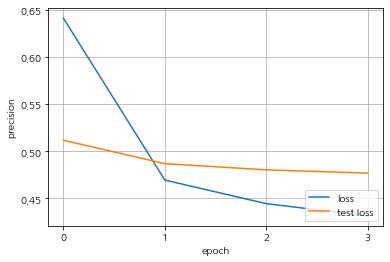

In [36]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.xticks(range(len(hist.history['loss'])))
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
# valid loss가 올라가는 순간 train data에 overfitting 
# epoch 중에 2,3 번까지만 하는 것이 가장 학습이 잘 되는 것으로 보임 -> epoch:20 -> epoch:3

In [37]:
pred_dl_prob = model.predict(test_X_dl)
pred_dl = np.argmax(pred_dl_prob, axis=1)

pred_dl

array([36, 20, 44, ..., 35,  0, 19], dtype=int64)

# 7. Evaluation
- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

def show_pred(test_y, pred) :
    #true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    #true_y = test_y.to_numpy()
    #true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

def classification_report_csv(report) : 
    df = pd.DataFrame(report).transpose()
    df.to_csv('classfication_report.csv', index=False)

In [39]:
# DL model 
print(classification_report(test_y, pred_dl)) # word embedding 

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.77      0.65      0.71     22760
           1       0.33      1.00      0.50         2
           2       0.84      0.76      0.80      4910
           3       0.82      0.79      0.80     15917
           4       0.86      0.74      0.80      9413
           5       0.79      0.77      0.78     12738
           6       0.67      0.40      0.50         5
           7       0.81      0.80      0.80      6527
           8       0.78      0.84      0.81     27195
           9       0.81      0.71      0.76     10681
          10       0.74      0.86      0.79       686
          11       0.76      0.86      0.81     45519
          12       0.84      0.75      0.79      1245
          13       0.00      0.00      0.00         2
          14       0.86      0.76      0.81      5621
          15       0.88      0.88      0.88     17952
          16       0.81      0.85      0.83     31834
          17       0.82    

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# ML model
#report = classification_report(test_y, pred_xgb, output_dict=True)
print(classification_report(test_y, pred_xgb))
#classification_report_csv(report)

              precision    recall  f1-score   support

           0       0.75      0.17      0.28     22760
           1       0.50      0.50      0.50         2
           2       0.62      0.35      0.44      4910
           3       0.65      0.07      0.12     15917
           4       0.60      0.16      0.25      9413
           5       0.62      0.30      0.41     12738
           6       0.80      0.80      0.80         5
           7       0.56      0.23      0.33      6527
           8       0.60      0.32      0.42     27195
           9       0.55      0.15      0.24     10681
          10       0.57      0.36      0.44       686
          11       0.54      0.89      0.67     45519
          12       0.58      0.40      0.48      1245
          13       1.00      1.00      1.00         2
          14       0.56      0.25      0.34      5621
          15       0.63      0.66      0.65     17952
          16       0.52      0.89      0.66     31834
          17       0.59    

In [39]:
# ML model
#report = classification_report(test_y, pred_lgbm, output_dict=True)
print(classification_report(test_y, pred_lgbm))
#classification_report_csv(report)

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.63      0.28      0.39    146388
           1       0.71      1.00      0.83         5
           2       0.54      0.90      0.68     45519
           3       0.52      0.91      0.66     31834
           4       0.53      0.90      0.67     18826
           5       0.55      0.86      0.67     25477
           6       0.57      0.72      0.63      9820
           7       0.54      0.87      0.67     21362
           8       0.00      0.00      0.00         2
           9       0.59      0.83      0.69     13054
          10       0.58      0.78      0.67      1372
          11       0.55      0.82      0.66     54389
          12       0.57      0.78      0.66      2489
          13       0.55      0.84      0.67      8349
          14       0.56      0.81      0.66     11242
          15       0.54      0.86      0.66     13132
          16       0.63      0.82      0.71     35903
          17       0.49    

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
show_prediction_error(test_y, pred_xgb)

<AxesSubplot:>

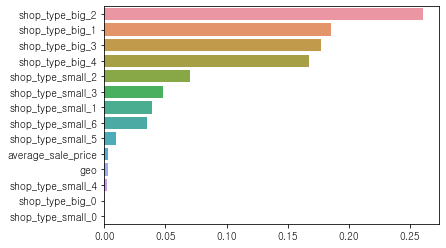

In [38]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X_ml.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

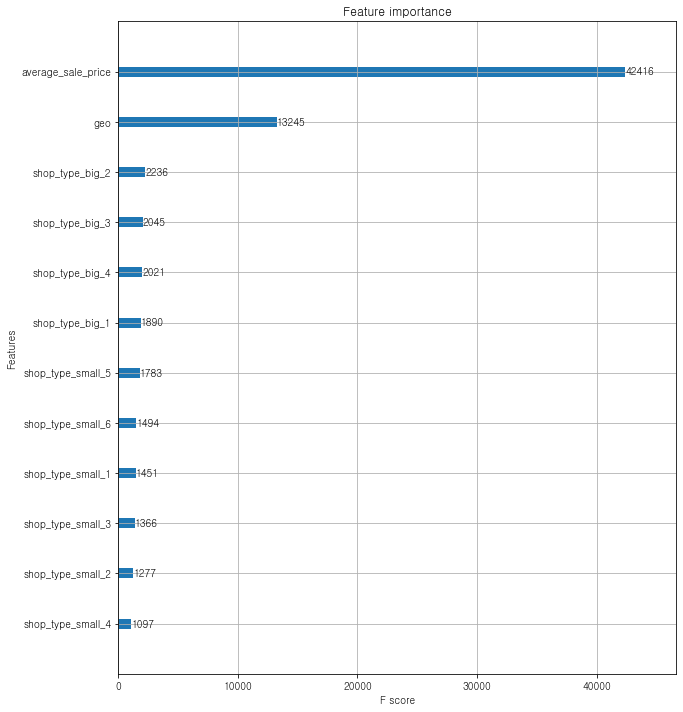

In [34]:
feature_importance(model_xgb)

# 8. Ensemble


In [51]:
pred_ensemble_prob = pred_xgb_prob * 0.5+ pred_dl_prob * 0.5
pred_ensemble = np.argmax(pred_ensemble_prob, axis=1)
pred_ensemble

array([29, 25,  9, ..., 31, 32, 15], dtype=int64)

In [52]:
print(classification_report(test_y, pred_ensemble))

              precision    recall  f1-score   support

           0       0.82      0.64      0.72     22760
           1       0.40      1.00      0.57         2
           2       0.84      0.78      0.81      4910
           3       0.87      0.72      0.79     15917
           4       0.87      0.75      0.81      9413
           5       0.86      0.69      0.77     12738
           6       0.67      0.40      0.50         5
           7       0.83      0.77      0.80      6527
           8       0.87      0.74      0.80     27195
           9       0.85      0.66      0.74     10681
          10       0.82      0.76      0.79       686
          11       0.76      0.87      0.81     45519
          12       0.85      0.77      0.81      1245
          13       1.00      0.50      0.67         2
          14       0.90      0.75      0.82      5621
          15       0.87      0.90      0.89     17952
          16       0.79      0.90      0.84     31834
          17       0.88    

# 9. Export for Web 

In [80]:
from keras.models import load_model
from pickle import dump
import pickle

In [35]:
model.save('model_dl.h5')

In [32]:
with open('model_ml.h5', 'wb') as file:  
    pickle.dump(model_xgb, file)

In [43]:
dump(encoder, open('encoder.pkl', 'wb'))

In [ ]:
dump(kmeans, open("kmeans.pkl", "wb"))

In [81]:
dump(le, open('labelEncoder.pkl', 'wb'))

In [30]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)